In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/conditions.db")

query = """
SELECT age, gender, patient
FROM (
    SELECT c.patient, p.gender, DATE(p.birthdate) as dob, min(DATE(c.start)) as start, (cast(strftime('%Y.%m%d', min(DATE(c.start))) - strftime('%Y.%m%d', DATE(p.birthdate)) as int) / 2) * 2 as age
    FROM conditions c
    JOIN patients p on c.patient = p.id
    WHERE c.description = 'Ischemic heart disease (disorder)'
    GROUP BY c.patient
    ORDER BY age
 ) h
WHERE age >= 20;
"""

df = pd.read_sql(query, conn)

In [3]:
delta = df.age.max() / df.count()[0] #TODO: is this the way?

In [4]:
import snsql
from snsql import Privacy

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'age': {
                    'name': 'age',
                    'type': 'int',
                    'lower': '0',
                    'upper': '100'
                },
                'gender': {
                    'name': 'gender',
                    'type': 'string'
                }
            }
        }
    }
}

In [5]:
def means(eps, times):
    privacy_ = Privacy(epsilon=eps, delta=delta)
    reader_ = snsql.from_connection(df, privacy=privacy_, metadata=metadata)
    means_ = pd.DataFrame(columns=['F', 'M'])
    for i in range(times):
        result_ = reader_.execute('SELECT gender, AVG(age) as age FROM MyTable GROUP BY gender')
        means_ = pd.concat([means_, pd.DataFrame([result_[1], result_[2]], columns=result_[0]).pivot_table(columns=['F', 'M'])])
    return means_

In [6]:
meansByEpsilon = {}
for i in range(20):
    eps = round(0.1 - (0.005 * i), 3)
    meansByEpsilon[eps] = means(eps, 100)

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(
/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts 

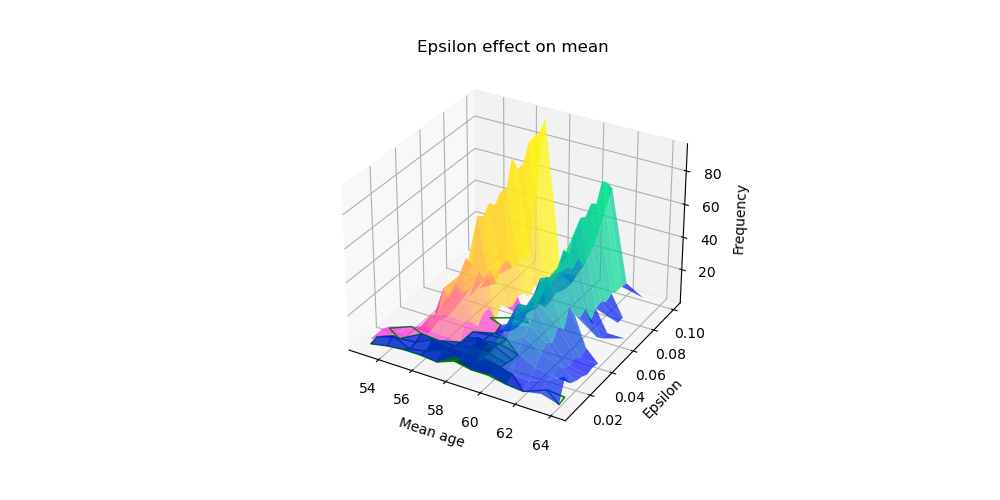

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5] #size

# function for z axis
def fw(x, y):
    y = round(y, 3)
    r = meansByEpsilon[y]['F'].where(round(meansByEpsilon[y].F) == x).count()
    return r if r > 0 else np.nan

def fm(x, y):
    y = round(y, 3)
    r = meansByEpsilon[y]['M'].where(round(meansByEpsilon[y].M) == x).count()
    return r if r > 0 else np.nan

# x and y axis
x = np.linspace(53, 64, 12) #age
y = np.linspace(0.1, 0.005, 20) #espilon
X, Y = np.meshgrid(x, y)

# women
Zw = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        Zw[i][j] = fw(X[i][j], Y[i][j])

# men
Zm = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        Zm[i][j] = fm(X[i][j], Y[i][j])

# intersection
Zi = np.zeros([20, 12])
for i in range(20):
    for j in range(12):
        w_ = Zw[i][j]
        m_ = Zm[i][j]
        if w_ > 0 and m_ > 0:
            Zi[i][j] = min(w_, m_)
        else:
            Zi[i][j] = np.nan

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_surface(X, Y, Zm, cmap ='spring', alpha=0.7, label='women')
ax.plot_surface(X, Y, Zw, cmap ='winter', alpha=0.7, label='men')
ax.plot_surface(X, Y, Zi, cmap ='Greens', alpha=1, label='intersection', edgecolors='g')
ax.set_ylabel('Epsilon')
ax.set_xlabel('Mean age')
ax.set_zlabel('Frequency')
ax.set_title('Epsilon effect on mean');

## Cohen's d

In [8]:
import pingouin as pg
xs = []
ys = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    d = pg.compute_effsize(f, m, paired=False, eftype='cohen')
    xs.append(k)
    ys.append(d)

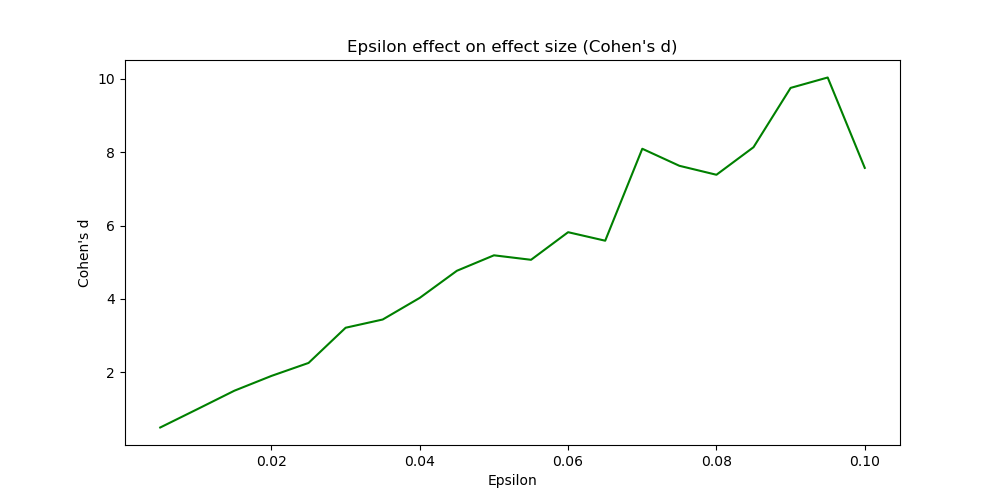

In [9]:
fig, ax = plt.subplots()
plt.plot(xs, ys, color="g")
plt.xlabel('Epsilon')
plt.ylabel("Cohen's d")
plt.title("Epsilon effect on effect size (Cohen's d)")
plt.show()

## Kolmogorov-Smirnov Test

In [10]:
from scipy.stats import ks_2samp
xs = []
ks = []
ps = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    ks_statistic, p_value = ks_2samp(f, m)
    xs.append(k)
    ks.append(ks_statistic)
    ps.append(p_value)

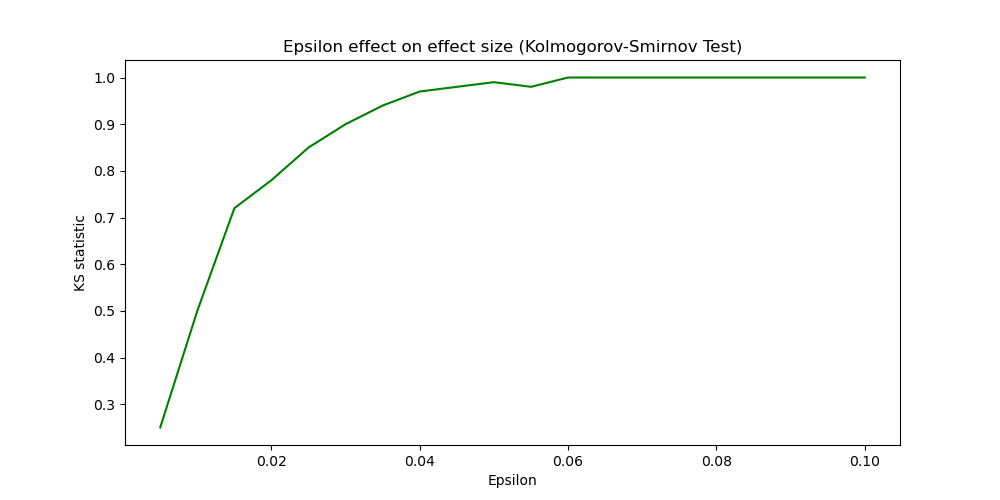

In [11]:
fig, ax = plt.subplots()
plt.plot(xs, ks, color="g")
# plt.plot(xs, ps, color="b")
plt.xlabel('Epsilon')
plt.ylabel('KS statistic')
plt.title('Epsilon effect on effect size (Kolmogorov-Smirnov Test)')
plt.show()

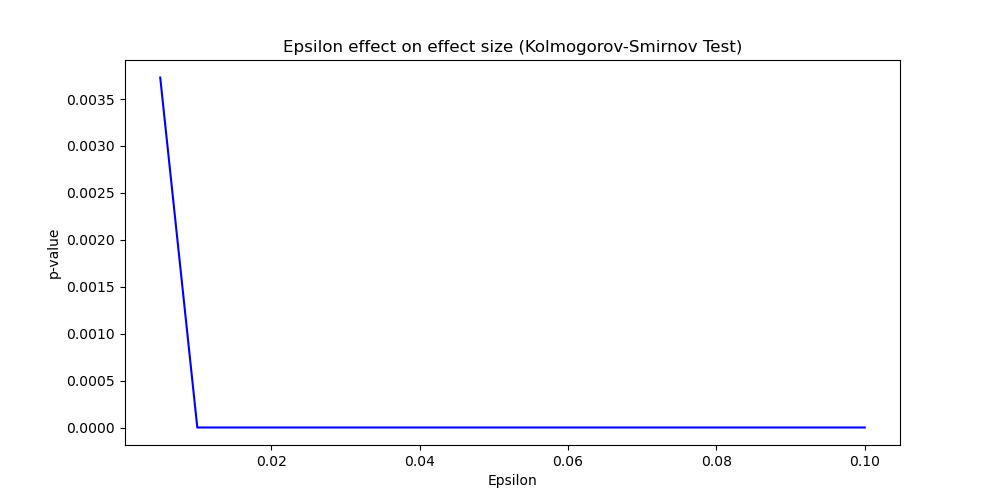

In [12]:
fig, ax = plt.subplots()
# plt.plot(xs, ks, color="g")
plt.plot(xs, ps, color="b")
plt.xlabel('Epsilon')
plt.ylabel('p-value')
plt.title('Epsilon effect on effect size (Kolmogorov-Smirnov Test)')
plt.show()

In [21]:
from scipy.stats import gaussian_kde
from scipy.integrate import trapz

xs = []
os = []
for k in meansByEpsilon:
    f = meansByEpsilon[k]["F"]
    m = meansByEpsilon[k]["M"]
    kde1 = gaussian_kde(f)
    kde2 = gaussian_kde(m)
    x_min = min(min(f), min(m))
    x_max = max(max(f), max(m))
    x = np.linspace(x_min, x_max, 1000)
    y1 = kde1(x)
    y2 = kde2(x)
    overlap = trapz(np.minimum(y1, y2), x)
    xs.append(k)
    os.append(overlap)

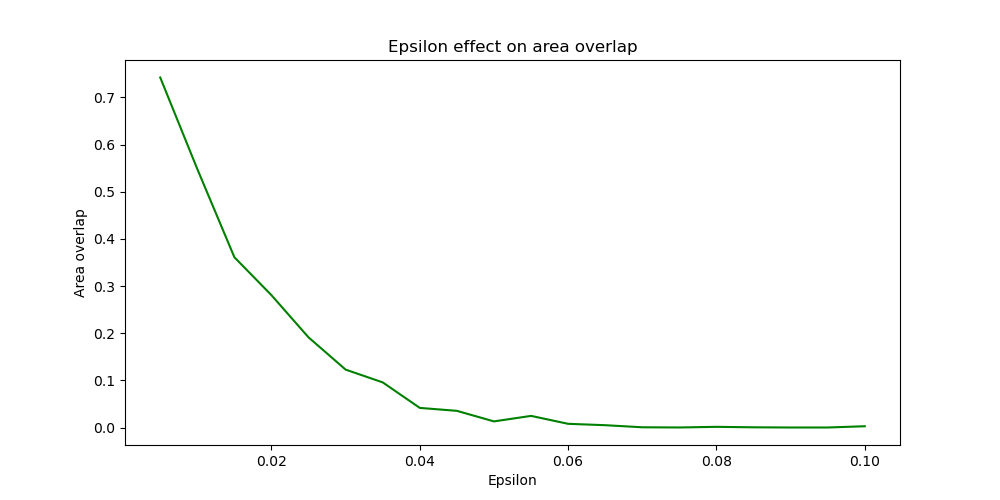

In [24]:
fig, ax = plt.subplots()
plt.plot(xs, os, color="g")
plt.xlabel('Epsilon')
plt.ylabel('Area overlap')
plt.title('Epsilon effect on area overlap')
plt.show()